In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import sys

src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

In [3]:
import pickle

import numpy as np
import pandas as pd

# Set the seed for Keras
np.random.seed(4)

from model.model import get_model, split_train_test

from model.predictions import fit_model, predict, assemble_submission, convert_predictions, AMAPE

from utils.visualisations import PenguinVisualisation

Using Theano backend.


In [4]:
fname = '../data/interim/features_weighted.p'
df_train, df_test, df_features, features, scaler = pickle.load(open(fname, 'rb'))

In [5]:
print(df_train.shape, df_test.shape)
df_train.head()

(49437, 26) (1296, 26)


y_true inferred_y_true inferred_t        t0  \
site_id species        year                                                
ACUN    adelie penguin 1984     1.0            True       True  1.000000   
                       1985     1.0            True       True  1.000000   
                       1986     1.0            True       True  1.000000   
                       1987     1.0            True       True  1.000000   
                       1987     1.0            True       True  1.047794   

                                   t1        t2        t3  countError  \
site_id species        year                                             
ACUN    adelie penguin 1984  1.000000  1.000000  1.000000    0.707107   
                       1985  1.000000  1.000000  1.000000    0.707107   
                       1986  1.000000  1.000000  1.000000    0.707107   
                       1987  1.000000  1.000000  1.000000    0.707107   
                       1987  1.430032  0.444188  0.956808    0.707107   

                             adelie penguin  chinstrap penguin    ...     \
site_id species        year                                       ...      
ACUN    adelie penguin 1984             1.0                0.0    ...      
                       1985             1.0                0.0    ...      
                       1986             1.0                0.0    ...      
                       1987             1.0                0.0    ...      
                       1987             1.0                0.0    ...      

                             sea_ice_month_3  sea_ice_month_4  \
site_id species        year                                     
ACUN    adelie penguin 1984         0.000000         0.000000   
                       1985         0.006667         0.000000   
                       1986         0.141111         0.000000   
                       1987         0.083611         0.000000   
                       1987         0.213962        -0.048997   

                             sea_ice_month_5  sea_ice_month_6  \
site_id species        year                                     
ACUN    adelie penguin 1984         0.007222         0.177222   
                       1985         0.000000         0.060278   
                       1986         0.000278         0.043889   
                       1987         0.150833         0.168333   
                       1987         0.027762         0.030819   

                             sea_ice_month_7  sea_ice_month_8  \
site_id species        year                                     
ACUN    adelie penguin 1984         0.000000         0.000000   
                       1985         0.059444         0.016111   
                       1986         0.150556         0.065000   
                       1987         0.164722         0.000000   
                       1987         0.244615         0.150252   

                             sea_ice_month_9  sea_ice_month_10  \
site_id species        year                                      
ACUN    adelie penguin 1984         0.064167          0.141944   
                       1985         0.000000          0.140000   
                       1986         0.003333          0.171944   
                       1987         0.151389          0.181667   
                       1987         0.223250          0.211193   

                             sea_ice_month_11     krill  
site_id species        year                              
ACUN    adelie penguin 1984          0.147778  1.051298  
                       1985          0.165556  5.788702  
                       1986          0.000000  0.000000  
                       1987          0.181667  0.000000  
                       1987          0.073681  2.182324  

[5 rows x 26 columns]

In [6]:
# Get the model
ts_steps = 4
aux_input_size = 6
model = get_model(ts_steps, aux_input_size=aux_input_size)

In [7]:
# Run the fitting
batch_size = 256
model, history = fit_model(df_train, model, df_test, batch_size=batch_size, epochs=400, verbose=0)

Epoch with lowest validation loss is epoch 244 with a loss of 0.20
Manually chosen epoch is epoch 175 with a loss of 1.06


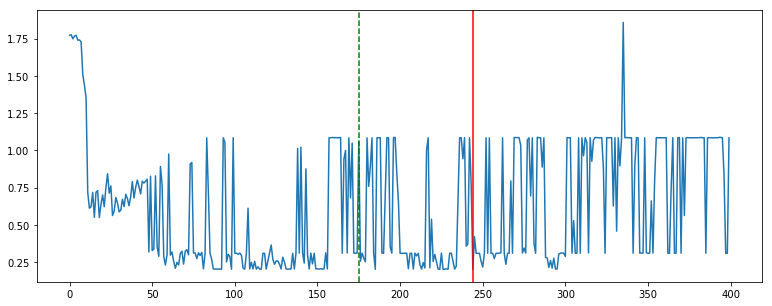

In [8]:
# Show the history of the validation loss and select the "best" number of epochs to run
val_loss = history.history['val_loss']
best_epoch_auto = np.argmin(val_loss)
best_epoch = 175

print("Epoch with lowest validation loss is epoch %i with a loss of %.2f" %(best_epoch_auto, val_loss[best_epoch_auto]))
print("Manually chosen epoch is epoch %i with a loss of %.2f" %(best_epoch, val_loss[best_epoch]))


fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(111)
ax.plot(val_loss)
ax.axvline(best_epoch, color='green', linestyle='dashed');
ax.axvline(best_epoch_auto, color='red');

In [9]:
# Get the model
ts_steps = 4
aux_input_size = 6
model = get_model(ts_steps, aux_input_size=aux_input_size)
model, history = fit_model(df_train, model, df_test, batch_size=batch_size, epochs=best_epoch, verbose=0)

Epoch with lowest validation loss is epoch 78 with a loss of 0.23


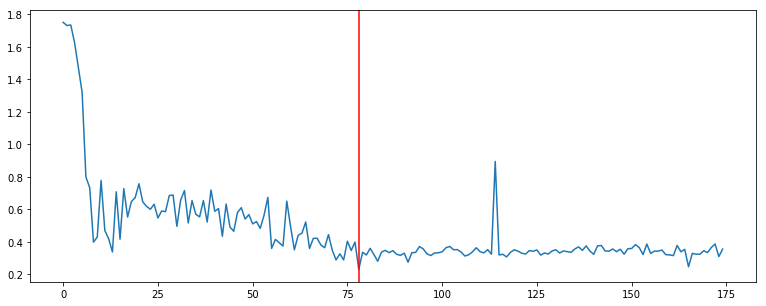

In [10]:
val_loss_re = history.history['val_loss']
best_epoch_re = np.argmin(val_loss_re)

print("Epoch with lowest validation loss is epoch %i with a loss of %.2f" %(best_epoch_re, val_loss_re[best_epoch_re]))

fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(111)
ax.plot(val_loss_re)
ax.axvline(best_epoch_re, color='red');

In [11]:
# Predict the steps ahead
df_predictions = predict(df_features, 4, model, features)
df_predictions.head()

adelie penguin  chinstrap penguin  countError  \
site_id species        year                                                  
ACUN    adelie penguin 1984             1.0                0.0    0.707107   
                       1985             1.0                0.0    0.707107   
                       1986             1.0                0.0    0.707107   
                       1987             1.0                0.0    0.707107   
                       1988             1.0                0.0    0.707107   

                             gentoo penguin inferred_t  inferred_y_true  \
site_id species        year                                               
ACUN    adelie penguin 1984             0.0       True              1.0   
                       1985             0.0       True              1.0   
                       1986             0.0       True              1.0   
                       1987             0.0       True              1.0   
                       1988             0.0       True              1.0   

                                krill  proximityNestCountChange  \
site_id species        year                                       
ACUN    adelie penguin 1984  1.051298                       1.0   
                       1985  5.788702                       1.0   
                       1986  0.000000                       1.0   
                       1987  0.000000                       1.0   
                       1988  4.264471                       1.0   

                             sea_ice_month_0  sea_ice_month_1   ...    \
site_id species        year                                     ...     
ACUN    adelie penguin 1984         0.000000              0.0   ...     
                       1985         0.000000              0.0   ...     
                       1986         0.143056              0.0   ...     
                       1987         0.049167              0.0   ...     
                       1988         0.000000              0.0   ...     

                             sea_ice_month_7  sea_ice_month_8  \
site_id species        year                                     
ACUN    adelie penguin 1984         0.000000         0.000000   
                       1985         0.059444         0.016111   
                       1986         0.150556         0.065000   
                       1987         0.164722         0.000000   
                       1988         0.054444         0.158889   

                             sea_ice_month_9  siteCount   t0   t1   t2   t3  \
site_id species        year                                                   
ACUN    adelie penguin 1984         0.064167         18  1.0  1.0  1.0  1.0   
                       1985         0.000000         18  1.0  1.0  1.0  1.0   
                       1986         0.003333         18  1.0  1.0  1.0  1.0   
                       1987         0.151389         18  1.0  1.0  1.0  1.0   
                       1988         0.151389         18  1.0  1.0  1.0  1.0   

                               y_pred  y_true  
site_id species        year                    
ACUN    adelie penguin 1984  0.937373     1.0  
                       1985  0.937662     1.0  
                       1986  0.937455     1.0  
                       1987  0.937455     1.0  
                       1988  0.937413     1.0  

[5 rows x 27 columns]

In [12]:
# Rescale the predictions
df_predictions = convert_predictions(df_predictions, scaler)
df_predictions.head()

year                                1984           1985           1986  \
site_id species                                                          
ACUN    adelie penguin       1882.244350    1882.824828    1882.409996   
        chinstrap penguin    3756.184101    3755.298138    3757.015228   
ADAM    adelie penguin         71.826717      71.794559      71.798210   
ADAR    adelie penguin     241397.868990  249624.759710  257833.483933   
AILS    chinstrap penguin    5634.251833    5632.940769    5635.522485   

year                                1987           1988           1989  \
site_id species                                                          
ACUN    adelie penguin       1882.409996    1882.324899    1882.409996   
        chinstrap penguin    3757.014990    3755.203724    3757.014990   
ADAM    adelie penguin         71.813725      71.801599      71.814795   
ADAR    adelie penguin     265854.032751  260628.369883  253489.359097   
AILS    chinstrap penguin    5635.522485    5632.813454    5635.522485   

year                                1990           1991           1992  \
site_id species                                                          
ACUN    adelie penguin       1882.409996    1882.409996    1882.409996   
        chinstrap penguin    3757.014990    3757.014990    3757.014990   
ADAM    adelie penguin         71.841662      71.804552      71.826482   
ADAR    adelie penguin     204637.437766  159704.610586  221448.707900   
AILS    chinstrap penguin    5635.522485    5635.522485    5635.522485   

year                                1993      ...                 2008  \
site_id species                               ...                        
ACUN    adelie penguin       1882.409996      ...          2340.148633   
        chinstrap penguin    3757.014990      ...          3755.410194   
ADAM    adelie penguin         71.762184      ...            71.842880   
ADAR    adelie penguin     281095.404918      ...        318987.845234   
AILS    chinstrap penguin    5635.522485      ...          5633.234739   

year                                2009           2010           2011  \
site_id species                                                          
ACUN    adelie penguin       2525.784772    2713.318711    2894.925446   
        chinstrap penguin    3756.868601    3757.014990    3757.014990   
ADAM    adelie penguin         71.779547      71.828960      71.789970   
ADAR    adelie penguin     317828.121845  318175.105750  318915.792962   
AILS    chinstrap penguin    5635.298610    5635.522485    5635.522485   

year                                2012           2013           2014  \
site_id species                                                          
ACUN    adelie penguin       2891.759679    2889.215688    2883.116311   
        chinstrap penguin    3757.014990    3757.014990    3751.228333   
ADAM    adelie penguin         71.818015      71.818015      71.840144   
ADAR    adelie penguin     349099.221992  377868.516534  406042.659549   
AILS    chinstrap penguin    5635.522485    5635.522485    5626.842499   

year                                2015           2016           2017  
site_id species                                                         
ACUN    adelie penguin       2695.914131    2517.626307    2347.449745  
        chinstrap penguin    3513.157077    3286.061000    3068.955976  
ADAM    adelie penguin         67.784391      63.903102      60.100888  
ADAR    adelie penguin     381445.653958  357423.094821  333823.567878  
AILS    chinstrap penguin    5269.735615    4929.091500    4603.433964  

[5 rows x 34 columns]

AMAPE 2011: 0.33
AMAPE 2012: 0.44
AMAPE 2013: 0.51
Projected AMAPE score: 1.28


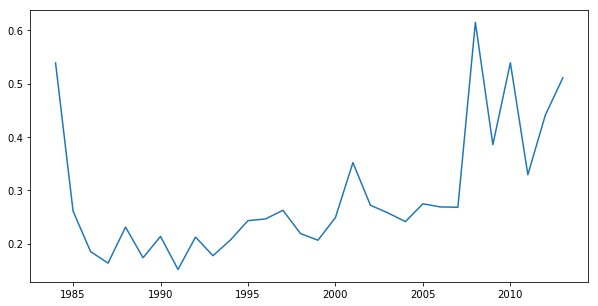

In [13]:
# Show some estimate of what the final score for the test set would be.
# First, show the score for all data (i.e. including the interpolated counts)
amape = AMAPE(interpolated=True)
amapeScore = amape.amape(df_predictions)

print("AMAPE 2011: %.2f" %amapeScore.loc['2011'])
print("AMAPE 2012: %.2f" %amapeScore.loc['2012'])
print("AMAPE 2013: %.2f" %amapeScore.loc['2013'])
print("Projected AMAPE score: %.2f" %(amapeScore.loc['2011']+amapeScore.loc['2012']+amapeScore.loc['2013']))

plt.figure(figsize=(10,5))
plt.plot(amapeScore);

AMAPE 2011: 2.06
AMAPE 2012: 2.15
AMAPE 2013: 3.42
Projected AMAPE score: 7.64


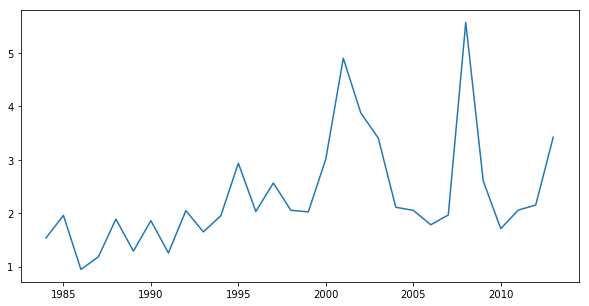

In [14]:
# Show the score only for the truly observed predictions. This will be harder to predict since the interpolated
# data is smooth and thus much easier to predict.
amape = AMAPE(interpolated=False)
amapeScore = amape.amape(df_predictions)

print("AMAPE 2011: %.2f" %amapeScore.loc['2011'])
print("AMAPE 2012: %.2f" %amapeScore.loc['2012'])
print("AMAPE 2013: %.2f" %amapeScore.loc['2013'])
print("Projected AMAPE score: %.2f" %(amapeScore.loc['2011']+amapeScore.loc['2012']+amapeScore.loc['2013']))

plt.figure(figsize=(10,5))
plt.plot(amapeScore);

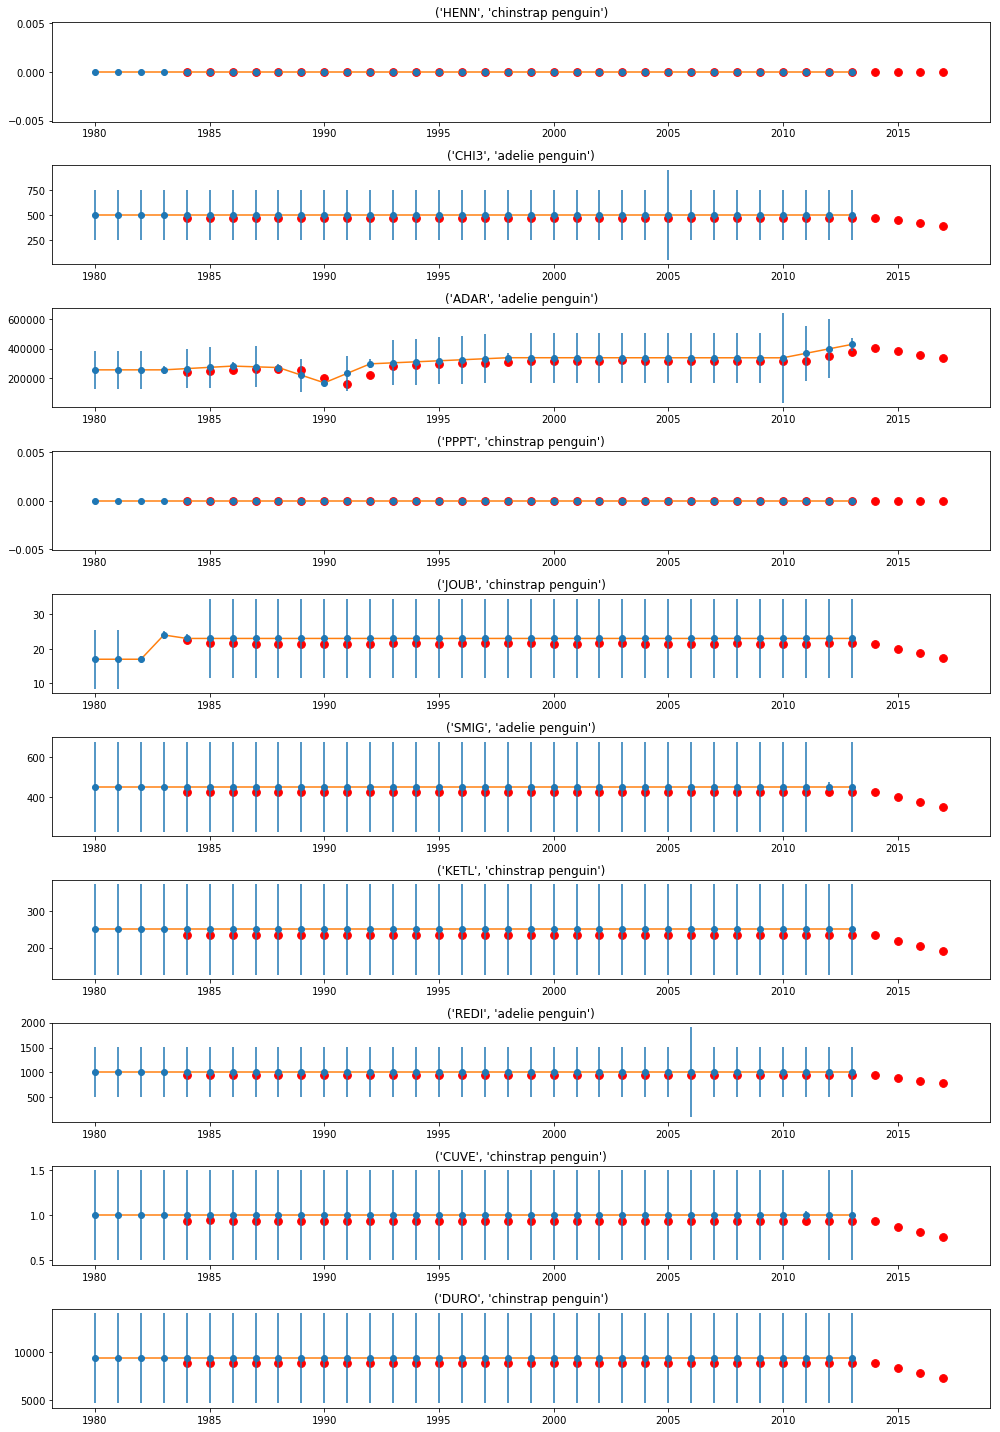

In [15]:
# Have look at some random sites and species and check if the model seems to make sense
vis = PenguinVisualisation(df_predictions)
vis.plot_random()

In [16]:
# Finally, retrain the model with the full data and make the predictions for the submission
model = get_model(ts_steps, aux_input_size=aux_input_size)
model, _ = fit_model(df_features, model, None, batch_size=batch_size, epochs=best_epoch, verbose=0)

# Make the predictions
df_predictions = predict(df_features, 4, model, features)
df_predictions = convert_predictions(df_predictions, scaler)

# Prepare the submission
df_submission = assemble_submission(df_predictions)
df_submission.head()

2014           2015           2016  \
site_id common_name                                                      
ACUN    adelie penguin       3080.891385    2884.887367    2697.570192   
        chinstrap penguin    4002.457142    3753.532658    3515.315158   
ADAM    adelie penguin         76.046686      71.884275      67.826029   
ADAR    adelie penguin     428779.231152  406292.085655  381679.970481   
AILS    chinstrap penguin    6003.685713    5630.298986    5272.972737   

                                    2017  
site_id common_name                       
ACUN    adelie penguin       2519.172848  
        chinstrap penguin    3288.079580  
ADAM    adelie penguin         63.942357  
ADAR    adelie penguin     357642.654635  
AILS    chinstrap penguin    4932.119369

In [17]:
fname_submission = '../data/submission/submission_01.csv'
df_submission.to_csv(fname_submission, index=True)

AMAPE 2011: 1.94
AMAPE 2012: 1.98
AMAPE 2013: 3.49
Projected AMAPE score: 7.41


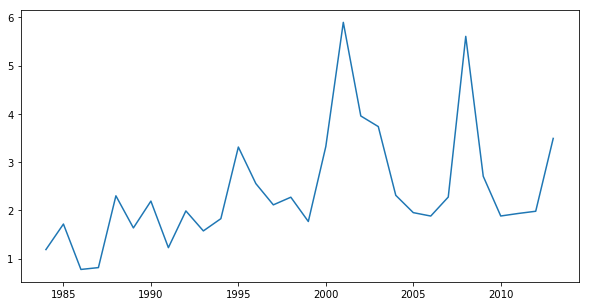

In [18]:
# Check if the score changes much compared to the run without the test data.
amape = AMAPE(interpolated=False)
amapeScore = amape.amape(df_predictions)

print("AMAPE 2011: %.2f" %amapeScore.loc['2011'])
print("AMAPE 2012: %.2f" %amapeScore.loc['2012'])
print("AMAPE 2013: %.2f" %amapeScore.loc['2013'])
print("Projected AMAPE score: %.2f" %(amapeScore.loc['2011']+amapeScore.loc['2012']+amapeScore.loc['2013']))

plt.figure(figsize=(10,5))
plt.plot(amapeScore);